In [2]:
import pandas as pd
import os
from pathlib import Path
import matplotlib.pyplot as plt
import matplotlib.patheffects as path_effects
import seaborn as sns


In [3]:
OUTPUT_DIR = "graphs"
DEFAULT_DPI = 300

In [4]:
plt.style.use('./modal.mplstyle')
palette = ['#bef264', '#fde047', '#6e47fd', '#add0e6', '#4ade80', '#fffdd0', '#efbe7d', '#dddddd']

In [5]:
dfs = []
for path in os.listdir("results"):
    filepath = Path("results", path)
    print(filepath)
    df = pd.read_json(filepath, lines=True)
    dfs.append(df)

results/result_whisperx-large-v2_1748828460.jsonl
results/result_nvidia-parakeet-tdt-0.6b-v2_1748880458.jsonl
results/result_openai-whisper-large-v3-turbo_1748873722.jsonl
results/result_whisperx-large-v2_1748828192.jsonl
results/result_whisperx-large-v2_1748828721.jsonl
results/result_nvidia-parakeet-tdt-0.6b-v2_1748828144.jsonl
results/result_openai-whisper-large-v3-turbo_1748873980.jsonl
results/result_openai-whisper-large-v3-turbo_1748873341.jsonl
results/result_nvidia-parakeet-tdt-0.6b-v2_1748827728.jsonl
results/result_nvidia-parakeet-tdt-0.6b-v2_1748827998.jsonl


In [6]:
df = pd.concat(dfs)

In [7]:
len(df)

110629

In [8]:
df.head()

,model,filename,expected_transcription,transcription,transcription_time,audio_duration,wer,gpu
0,whisperx-large-v2,LJ050-0045.wav,and of the Advanced Research Projects Agency o...,and of the Advanced Research Projects Agency ...,13.312898,4.430500,0.083333,h100
1,whisperx-large-v2,LJ049-0089.wav,"The murder of Federal judges, U.S. attorneys a...","The murder of federal judges, U.S. attorneys ...",12.290971,6.845375,0.187500,h100
2,whisperx-large-v2,LJ048-0137.wav,there have been references to the numerous dis...,There have been references to the numerous di...,14.471623,7.182062,0.058824,h100
3,whisperx-large-v2,LJ047-0214.wav,"End quote. Mr. Bouck pointed out, however, tha...","Mr. Book pointed out, however, that he had no...",11.922616,9.504062,0.200000,h100
4,whisperx-large-v2,LJ047-0036.wav,"It revealed his letter of January thirty, nine...","It revealed his letter of January 30, 1962, t...",11.979433,6.915000,0.266667,h100


In [9]:
pricing_per_second = {
    "CPU": 0.0000131, # 1 core
    "T4": 0.000164,
    "A10G": 0.000306,
    "H100": 0.001097,
}

In [10]:
model_to_display_name = {
    'nvidia-parakeet-tdt-0.6b-v2': "parakeet",
    'openai-whisper-large-v3-turbo': "whisper",
    'whisperx-large-v2': "whisperx",
}

In [11]:
# models = ['whisperx-large-v2', 'nvidia-parakeet-tdt-0.6b-v2',
#        'openai-whisper-large-v3-turbo']


In [12]:
# models 

In [46]:
# Clean
df["gpu"] = df["gpu"].str.upper()
df = df[df["audio_duration"] > 0]

# df["normalized_time"] = df["transcription_time"] / df["audio_duration"]
# df["cost"] = df["transcription_time"] * df["gpu"].map(pricing_per_second)
# df["cost_per_token"] = df["cost"] / df["token_count"]


# Utils
# models = ['nvidia-parakeet-tdt-0.6b-v2', 'openai-whisper-large-v3-turbo', 'whisperx-large-v2']
models = list(model_to_display_name.keys())
gpus = list(pricing_per_second.keys())
gpus_no_cpu = [g for g in gpus if g != "CPU"]

# Cost / token things
df["token_count"] = df["expected_transcription"].str.split().str.len()
df["cost"] = df.apply(lambda row: row["transcription_time"] * pricing_per_second.get(row["gpu"], 0), axis=1)
df = df[df["token_count"] > 0]
df["cost_per_token"] = df["cost"] / df["token_count"]
df["cost_per_second"] = df["cost"] / df["audio_duration"]
df["cost_per_minute"] = df["cost_per_second"] * 60

# RTFX
df["rtfx"] = df["audio_duration"]/df["transcription_time"]


In [14]:
df["gpu"].unique()


array(['H100', 'CPU', 'A10G', 'T4'], dtype=object)

In [15]:
df[df["gpu"]=="CPU"]["cost"].describe()

count    11063.000000
mean         0.000019
std          0.000006
min          0.000006
25%          0.000015
50%          0.000019
75%          0.000023
max          0.000060
Name: cost, dtype: float64

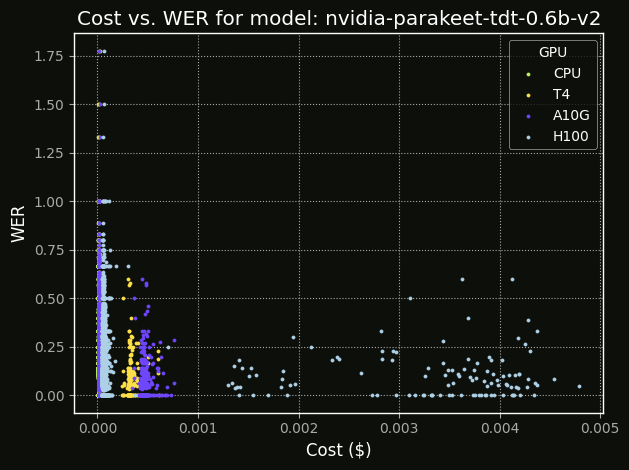

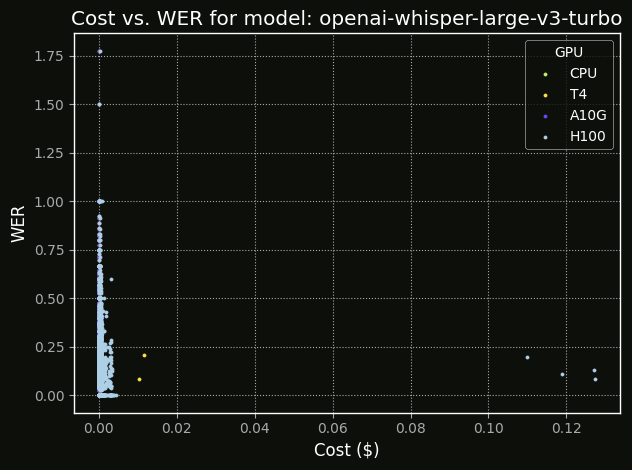

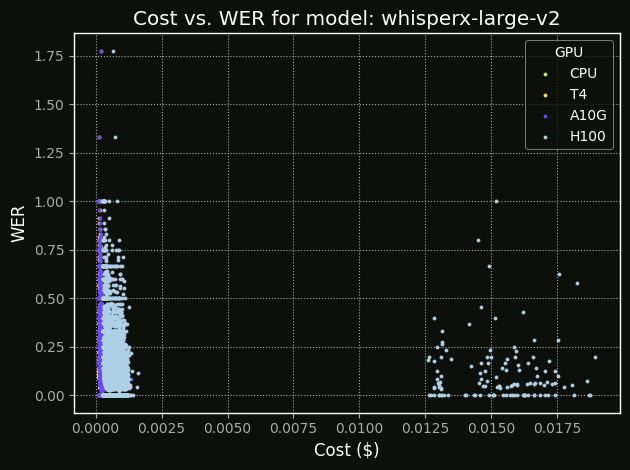

In [16]:

for model in models:
    subset = df[df["model"] == model]
    plt.figure()
    for gpu in gpus:
        gpu_data = subset[subset["gpu"] == gpu]
        plt.scatter(gpu_data["cost"], gpu_data["wer"], label=gpu,s=5)
    
    plt.title(f"Cost vs. WER for model: {model}")
    plt.xlabel("Cost ($)")
    plt.ylabel("WER")
    plt.legend(title="GPU")
    plt.grid(True)
    plt.tight_layout()
    plt.show()


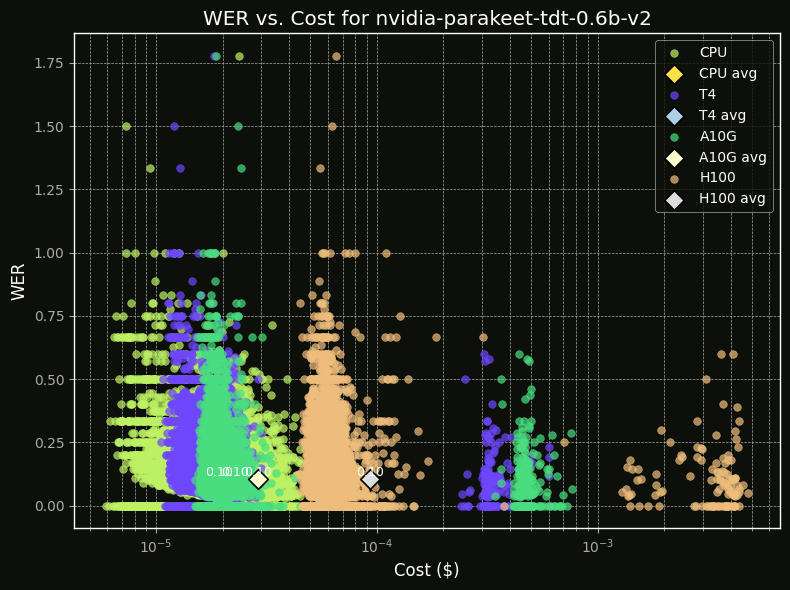

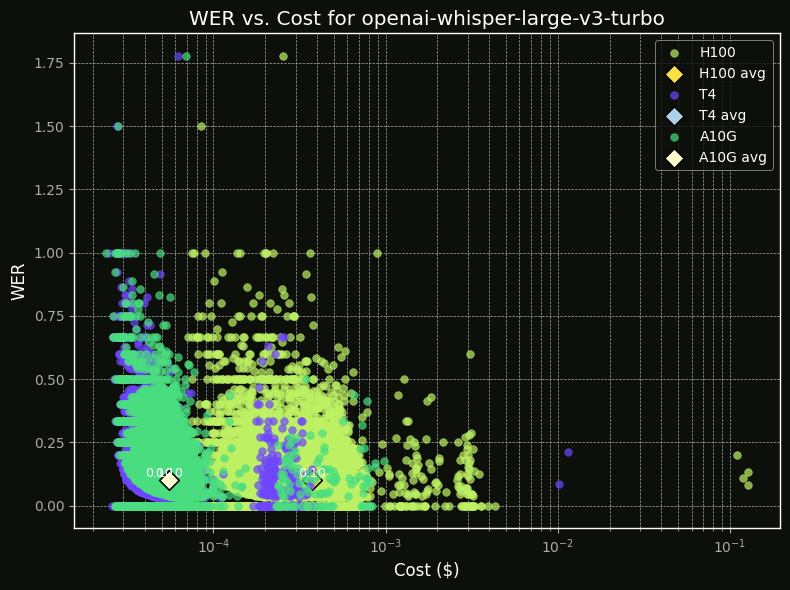

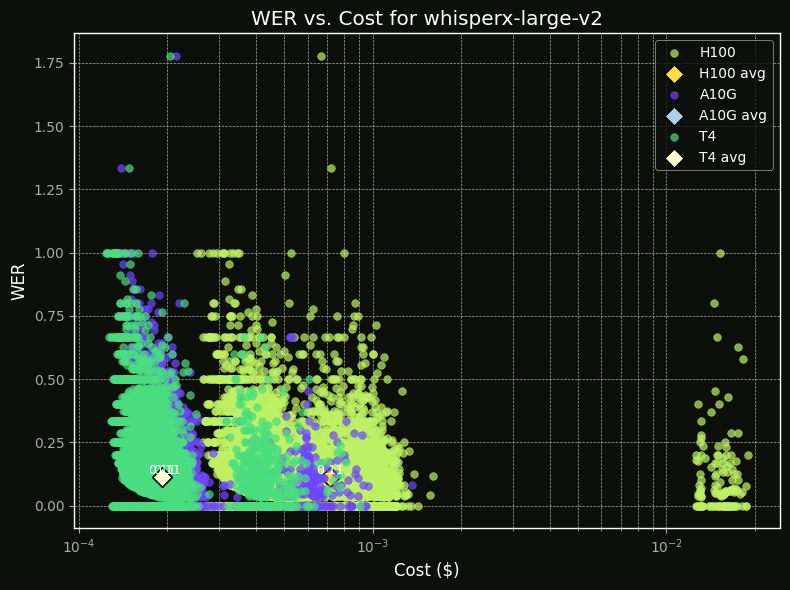

In [17]:

for model in models:
    subset = df[df["model"] == model]
    plt.figure(figsize=(8, 6))

    # Plot individual points (WER vs. cost), colored by GPU
    for gpu in subset["gpu"].unique():
        gpu_data = subset[subset["gpu"] == gpu]
        plt.scatter(
            gpu_data["cost"], 
            gpu_data["wer"], 
            label=gpu, 
            s=30, 
            alpha=0.7
        )

        # Plot average WER as a diamond
        avg_cost = gpu_data["cost"].mean()
        avg_wer = gpu_data["wer"].mean()
        plt.scatter(
            avg_cost, avg_wer,
            marker='D', s=100, label=f"{gpu} avg", edgecolors='black', linewidths=1.2
        )
        plt.text(
            avg_cost, avg_wer, f"{avg_wer:.2f}", fontsize=9,
            va='bottom', ha='center'
        )

    plt.title(f"WER vs. Cost for {model}")
    plt.xlabel("Cost ($)")
    plt.ylabel("WER")
    # plt.yscale("log")  # 👈 Logarithmic scale on Y
    plt.xscale("log")  # 👈 Logarithmic scale on Y
    plt.grid(True, which="both", linestyle="--", linewidth=0.5)
    plt.legend()
    plt.tight_layout()
    plt.show()

In [18]:
print(gpus)
print(models)

['CPU', 'T4', 'A10G', 'H100']
['nvidia-parakeet-tdt-0.6b-v2', 'openai-whisper-large-v3-turbo', 'whisperx-large-v2']


In [19]:
# df["gpu"] = df["gpu"].str.upper()
# df["model"] = df["model"].astype(str)

# # Preprocessing
# # df = df[df["audio_duration"] > 0]
# # df["cost"] = df["transcription_time"] * df["gpu"].map(pricing_per_second)
# # df = df[df["token_count"] > 0]
# # df["cost_per_token"] = df["cost"] / df["token_count"]

# # Group by (model, gpu) and compute averages
# agg_df = df.groupby(["model", "gpu"], as_index=False).agg({
#     "wer": "mean",
#     "cost_per_token": "mean"
# })

# # Plot
# plt.figure(figsize=(8, 6))
# markers = {"A10G": "o", "H100": "s", "T4": "D"}
# colors = {"whisperx-large-v2": "tab:blue", "whisperx-medium": "tab:green", "whisperx-small": "tab:orange"}  # adjust as needed

# for _, row in agg_df.iterrows():
#     model = row["model"]
#     gpu = row["gpu"]
#     x = row["cost_per_token"]
#     y = row["wer"]

#     plt.scatter(x, y, s=100, marker=markers.get(gpu, "o"), color=colors.get(model, "gray"), label=f"{model} / {gpu}")
#     plt.text(x, y, f"{model.split('-')[-1]} / {gpu}", fontsize=8, ha="center", va="bottom")

# plt.xscale("log")
# plt.yscale("log")
# plt.xlabel("Average Cost per Token ($)")
# plt.ylabel("Average WER")
# plt.title("WER vs. Cost per Token by Model and GPU")
# plt.grid(True, which="both", linestyle="--", linewidth=0.5)
# plt.tight_layout()
# plt.show()


In [20]:
# Group by (model, gpu) and compute averages
agg_df = df.groupby(["model", "gpu"], as_index=False).agg({
    "wer": "median",
    "cost_per_token": "median"
})


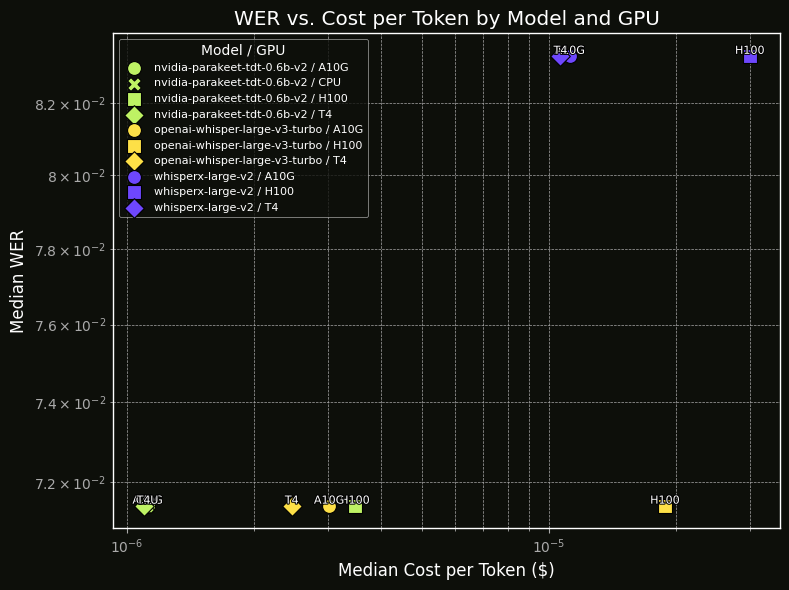

In [21]:
# Markers per GPU
markers = {
    "A10G": "o",
    "CPU": "X",
    "H100": "s",
    "T4": "D"
}

# Colors per Model
colors = {
    "nvidia-parakeet-tdt-0.6b-v2": palette[0],
    "openai-whisper-large-v3-turbo": palette[1],
    "whisperx-large-v2": palette[2],
}

# Track what's already been labeled to avoid duplicate legend entries
seen_labels = set()

plt.figure(figsize=(8, 6))

for _, row in agg_df.iterrows():
    model = row["model"]
    gpu = row["gpu"]
    x = row["cost_per_token"]
    y = row["wer"]

    marker = markers.get(gpu, "o")
    color = colors.get(model, "gray")
    label = f"{model} / {gpu}"

    # Only add to legend once per label
    if label not in seen_labels:
        plt.scatter(x, y, s=100, marker=marker, color=color, label=label, edgecolors='black', linewidths=0.8)
        seen_labels.add(label)
    else:
        plt.scatter(x, y, s=100, marker=marker, color=color, edgecolors='black', linewidths=0.8)

    # Optional: shorter inline label instead of model name
    text = plt.text(x, y, f"{gpu}", fontsize=8, ha="center", va="bottom")
            
    # Add drop shadow
    text.set_path_effects([
        path_effects.Stroke(linewidth=1.5, foreground='black'),  # shadow color and size
        path_effects.Normal()
    ])

# Final touches
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Median Cost per Token ($)")
plt.ylabel("Median WER")
plt.title("WER vs. Cost per Token by Model and GPU")
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.legend(title="Model / GPU", fontsize=8)
plt.tight_layout()
plt.savefig(Path(OUTPUT_DIR, "audio_wer_vs_cost.webp"), dpi=DEFAULT_DPI)
plt.show()


In [22]:
# def filter_outliers_iqr(group, column="normalized_time"):
#     Q1 = group[column].quantile(0.25)
#     Q3 = group[column].quantile(0.75)
#     IQR = Q3 - Q1
#     return group[(group[column] >= Q1 - 1.5 * IQR) & (group[column] <= Q3 + 1.5 * IQR)]


In [23]:

# # Normalize GPU and model names
# df["model"] = df["model"].astype(str)

# # Compute normalized transcription time
# df["normalized_time"] = df["transcription_time"] / df["audio_duration"]

# # Filter out outliers
# Q1 = df["normalized_time"].quantile(0.25)
# Q3 = df["normalized_time"].quantile(0.75)
# IQR = Q3 - Q1
# # df_filtered = df[(df["normalized_time"] >= Q1 - 1.5 * IQR) & (df["normalized_time"] <= Q3 + 1.5 * IQR)]
# # df_filtered = df.groupby(["model", "gpu"], group_keys=False).apply(filter_outliers_iqr)
# df_filtered = df[df["normalized_time"] <= 20]


# # Unique values
# models = sorted(df["model"].unique())
# gpus = sorted(df["gpu"].unique())
# gpus

In [24]:
# upper_bound = 3
# # Set up 3x3 subplot
# fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 12))
# fig.suptitle("Normalized Transcription Time per Model/GPU", fontsize=16)

# # Plot each model-GPU combo
# for i, model in enumerate(models):
#     for j, gpu in enumerate(gpus_no_cpu):
#         ax = axes[i, j]
#         subset = df[(df["model"] == model) & (df["gpu"] == gpu) & (df["normalized_time"] <= upper_bound)]

#         if not subset.empty:
#             sns.violinplot(data=subset, y="normalized_time", ax=ax, color="lightgray", inner=None, linewidth=1.2)
#             sns.boxplot(data=subset, y="normalized_time", ax=ax, color="skyblue", width=0.3)
        
#         ax.set_title(f"{model} / {gpu}")
#         ax.set_ylabel("Normalized Time (s/s)")
#         ax.set_xlabel("")
#         ax.set_ylim(0, upper_bound * 1.1)

# plt.tight_layout(rect=[0, 0, 1, 0.97])
# plt.show()

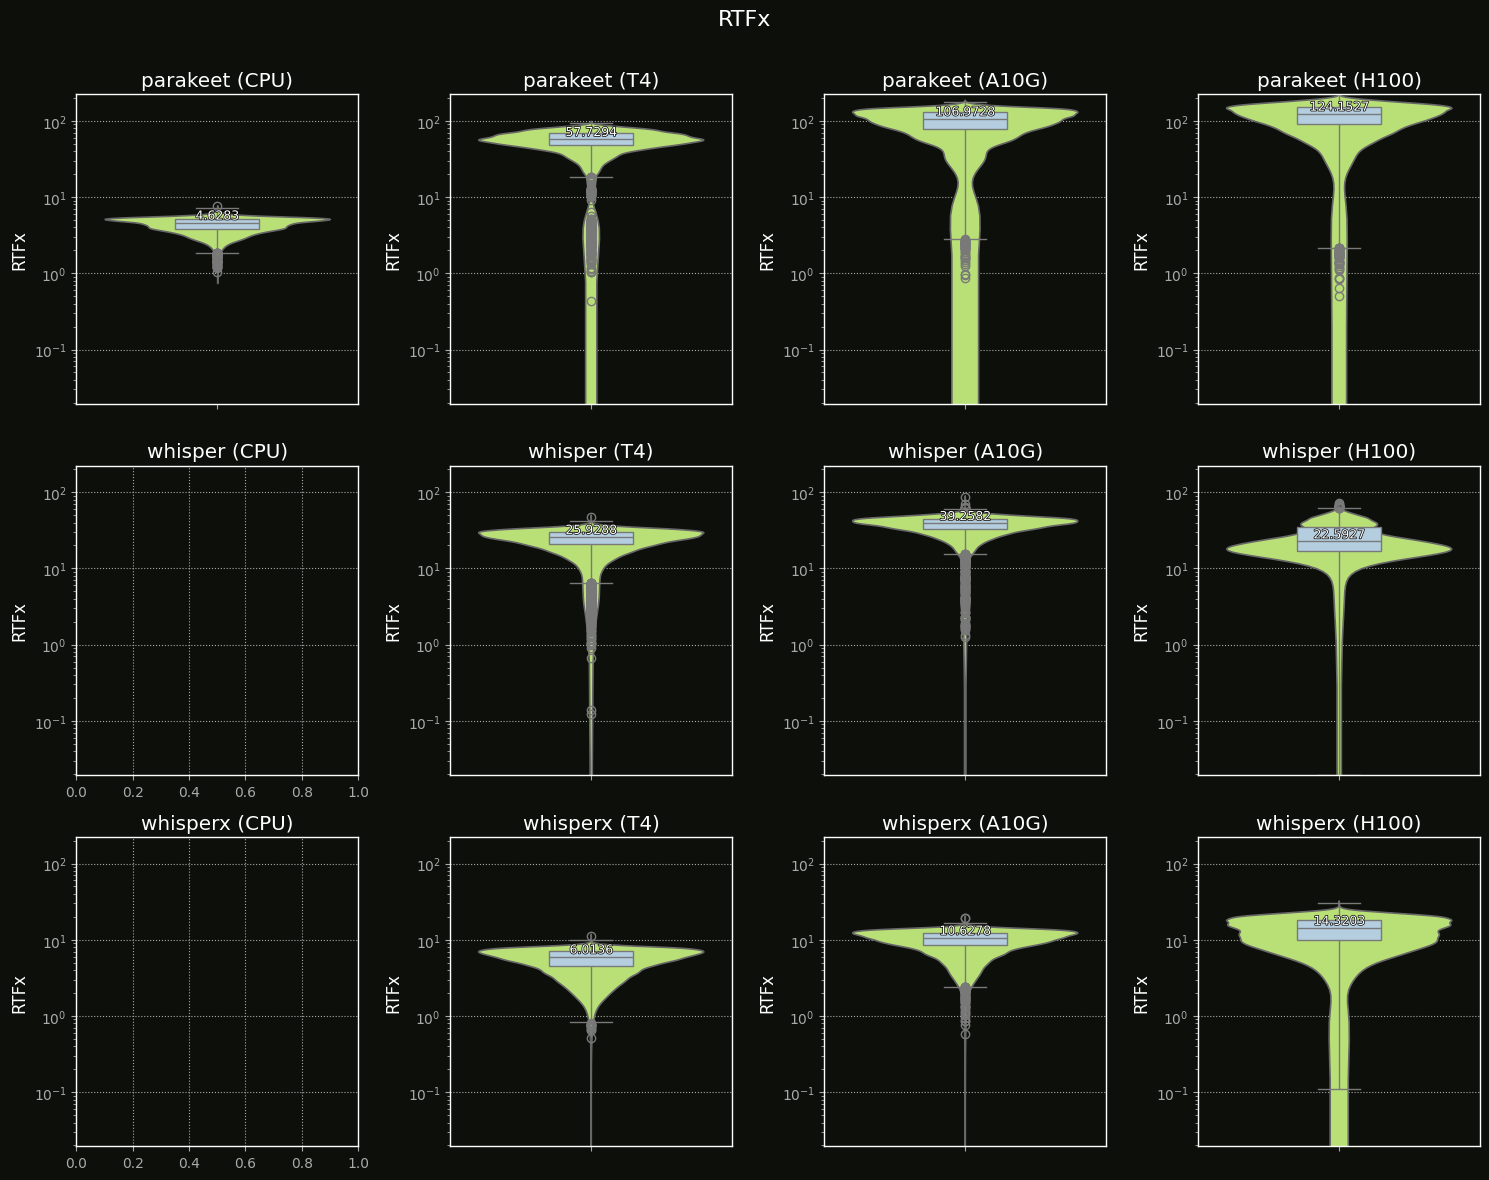

In [25]:
# Calculate global y-limits
rtfx_min = df["rtfx"].min()
rtfx_max = df["rtfx"].max()

# Create 3x3 plot grid
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(15, 12))
fig.suptitle("RTFx", fontsize=16)

# Plot
for i, model in enumerate(models):
    for j, gpu in enumerate(gpus):
        ax = axes[i, j]
        subset = df[(df["model"] == model) & (df["gpu"] == gpu)]

        if not subset.empty:
            sns.violinplot(data=subset, y="rtfx", ax=ax,inner=None, linewidth=1.2, color=palette[0])
            sns.boxplot(data=subset, y="rtfx", ax=ax, width=0.3, color=palette[3])


            # Calculate and add median label
            median_val = subset["rtfx"].median()
            text = ax.text(
                x=0, 
                y=median_val, 
                s=f"{median_val:.4f}", 
                ha='center', 
                va='bottom',
                fontsize=9,
                color='white',
            )
            
            # Add drop shadow
            text.set_path_effects([
                path_effects.Stroke(linewidth=1, foreground='black'),  # shadow color and size
                path_effects.Normal()
            ])
        
        ax.set_title(f"{model_to_display_name[model]} ({gpu})")
        ax.set_ylabel("RTFx")
        ax.set_yscale("log")  # Logarithmic Y-axis
        ax.set_xlabel("")
        ax.set_ylim(rtfx_min, rtfx_max)  # Shared y-axis

plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.savefig(Path(OUTPUT_DIR, "audio_rtfx.webp"), dpi=DEFAULT_DPI)
plt.show()


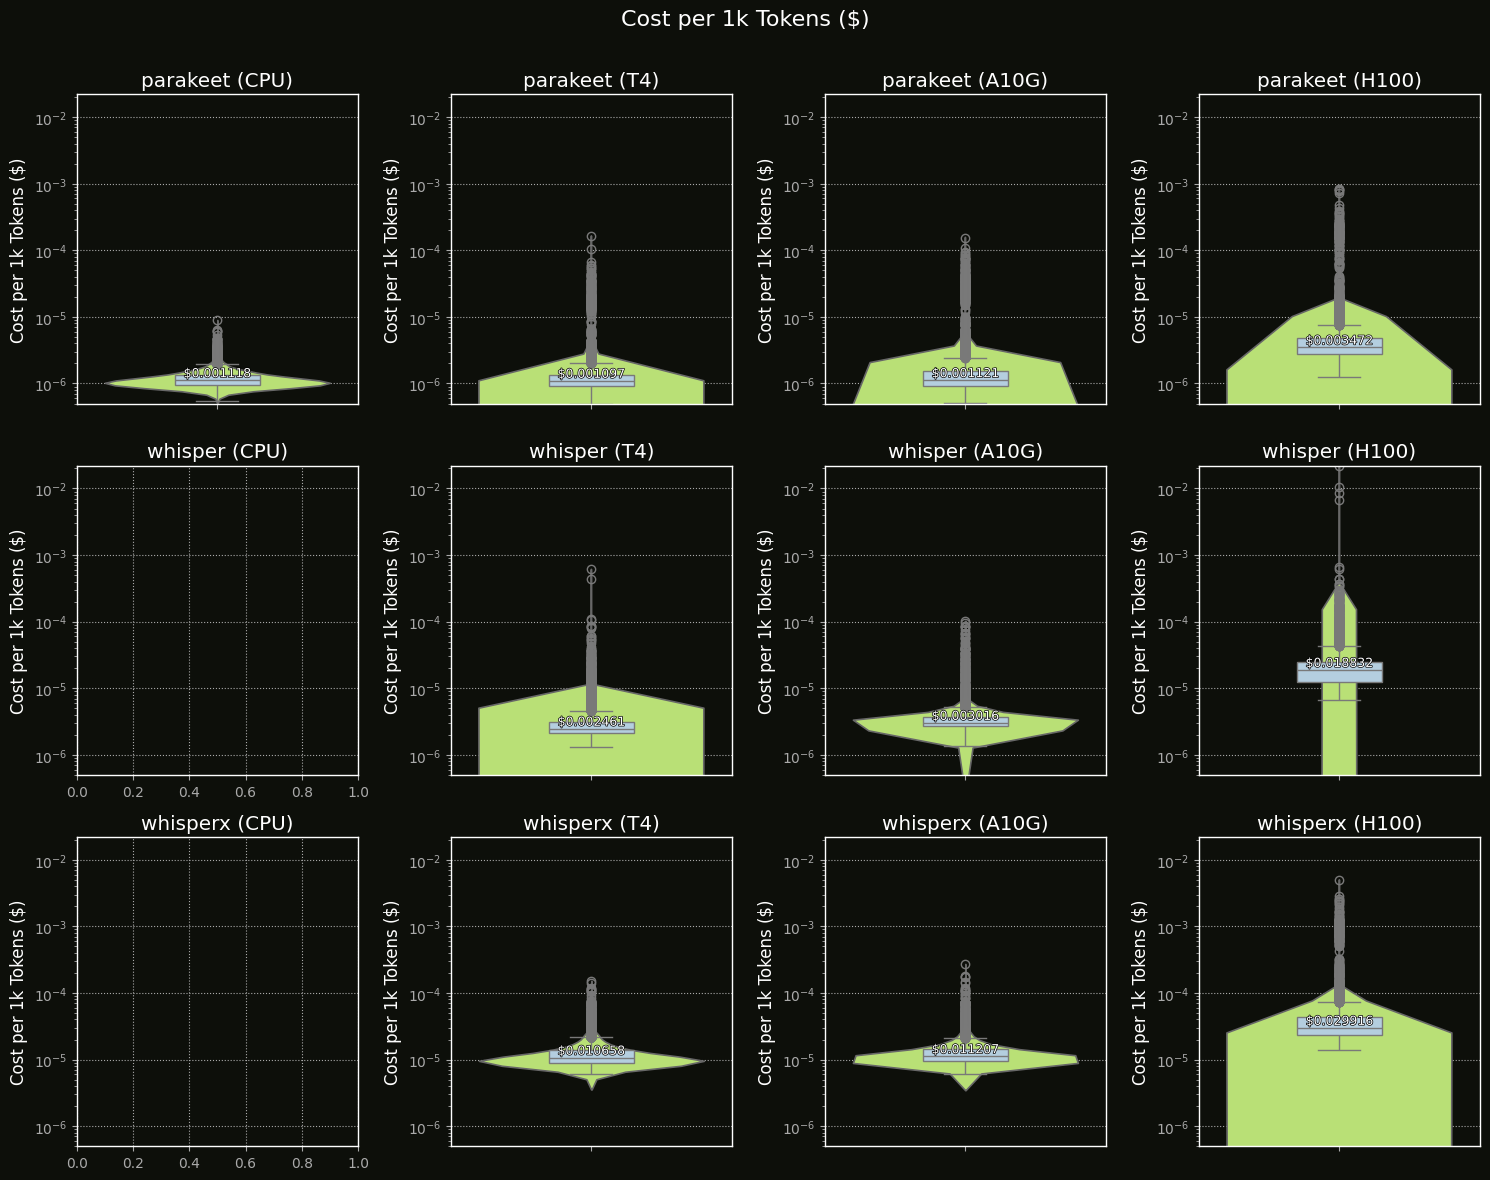

In [26]:
# Calculate global y-limits
cost_per_token_min = df["cost_per_token"].min()
cost_per_token_max = df["cost_per_token"].max()

fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(15, 12))
fig.suptitle("Cost per 1k Tokens ($)", fontsize=16)

# Plot per model-GPU combo
for i, model in enumerate(models):
    for j, gpu in enumerate(gpus):
        ax = axes[i, j]
        subset = df[(df["model"] == model) & (df["gpu"] == gpu)]

        if not subset.empty:
            sns.violinplot(data=subset, y="cost_per_token", ax=ax, color=palette[0], inner=None, linewidth=1.2)
            sns.boxplot(data=subset, y="cost_per_token", ax=ax, color=palette[3], width=0.3)

            # Add median label
            median_val = subset["cost_per_token"].median()
            text = ax.text(
                x=0, 
                y=median_val, 
                s=f"${median_val*1000:.6f}",
                ha='center', 
                va='bottom',
                fontsize=9,
                color='white',
            )
            
            # Add drop shadow
            text.set_path_effects([
                path_effects.Stroke(linewidth=1, foreground='black'),  # shadow color and size
                path_effects.Normal()
            ])

        ax.set_title(f"{model_to_display_name[model]} ({gpu})")
        ax.set_ylabel("Cost per 1k Tokens ($)")
        ax.set_yscale("log")
        ax.set_xlabel("")
        ax.set_ylim(cost_per_token_min, cost_per_token_max)  # Shared y-axis

plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.savefig(Path(OUTPUT_DIR, "audio_cost_per_1k_tokens.webp"), dpi=DEFAULT_DPI)
plt.show()

In [47]:




# Group and summarize
summary_df = (
    df.groupby(["model", "gpu"], as_index=False)
      .agg(
          rtfx=("rtfx", "median"),
          cost_per_token=("cost_per_token", "median"),
          median_wer=("wer", "median"),
          cost_per_second=("cost_per_second", "median"),
          cost_per_minute=("cost_per_minute", "median"),
          # mean_wer=("wer", "mean")  # optional
      )
      .sort_values(["model", "gpu"])
)
summary_df["cost_per_1k_tokens"] = summary_df["cost_per_token"] * 1000

# Format nicely
pd.set_option("display.float_format", lambda x: f"{x:.6f}")
print(summary_df)


                           model   gpu       rtfx  cost_per_token  median_wer  \
0    nvidia-parakeet-tdt-0.6b-v2  A10G 106.972806        0.000001    0.071429   
1    nvidia-parakeet-tdt-0.6b-v2   CPU   4.628257        0.000001    0.071429   
2    nvidia-parakeet-tdt-0.6b-v2  H100 124.152685        0.000003    0.071429   
3    nvidia-parakeet-tdt-0.6b-v2    T4  57.729403        0.000001    0.071429   
4  openai-whisper-large-v3-turbo  A10G  39.258226        0.000003    0.071429   
5  openai-whisper-large-v3-turbo  H100  22.592707        0.000019    0.071429   
6  openai-whisper-large-v3-turbo    T4  25.928770        0.000002    0.071429   
7              whisperx-large-v2  A10G  10.627797        0.000011    0.083333   
8              whisperx-large-v2  H100  14.320318        0.000030    0.083333   
9              whisperx-large-v2    T4   6.013595        0.000011    0.083333   

   cost_per_second  cost_per_minute  cost_per_1k_tokens  
0         0.000003         0.000172            0.0

In [49]:
# Select and rename relevant columns for clarity
styled_df = summary_df[["model", "gpu", "rtfx", "cost_per_1k_tokens", "cost_per_second", "cost_per_minute"]].copy()

# Use pandas Styler to colorize
def colorize(df):
    return (
        df.style
        .background_gradient(subset=["rtfx"], cmap="RdYlGn_r")  # green = high
        .background_gradient(subset=["cost_per_1k_tokens"], cmap="RdYlGn_r")  # green = cheap
        .background_gradient(subset=["cost_per_second"], cmap="RdYlGn_r")  # green = cheap
        .background_gradient(subset=["cost_per_minute"], cmap="RdYlGn_r")  # green = cheap
        .format({
            "rtfx": "{:.6f}",
            "cost_per_1k_tokens": "${:.6f}"
        })
    )

# Display styled table
colorize(styled_df)


,model,gpu,rtfx,cost_per_1k_tokens,cost_per_second,cost_per_minute
0,nvidia-parakeet-tdt-0.6b-v2,A10G,106.972806,$0.001121,0.000003,0.000172
1,nvidia-parakeet-tdt-0.6b-v2,CPU,4.628257,$0.001118,0.000003,0.000170
2,nvidia-parakeet-tdt-0.6b-v2,H100,124.152685,$0.003472,0.000009,0.000530
3,nvidia-parakeet-tdt-0.6b-v2,T4,57.729403,$0.001097,0.000003,0.000170
4,openai-whisper-large-v3-turbo,A10G,39.258226,$0.003016,0.000008,0.000468
5,openai-whisper-large-v3-turbo,H100,22.592707,$0.018832,0.000049,0.002913
6,openai-whisper-large-v3-turbo,T4,25.928770,$0.002461,0.000006,0.000380
7,whisperx-large-v2,A10G,10.627797,$0.011207,0.000029,0.001728
8,whisperx-large-v2,H100,14.320318,$0.029916,0.000077,0.004596
9,whisperx-large-v2,T4,6.013595,$0.010658,0.000027,0.001636


In [29]:
summary_df["rtfx"]

0   106.972806
1     4.628257
2   124.152685
3    57.729403
4    39.258226
5    22.592707
6    25.928770
7    10.627797
8    14.320318
9     6.013595
Name: rtfx, dtype: float64

In [30]:
print(summary_df[["model", "gpu", "rtfx", "cost_per_1k_tokens"]])

                           model   gpu       rtfx  cost_per_1k_tokens
0    nvidia-parakeet-tdt-0.6b-v2  A10G 106.972806            0.001121
1    nvidia-parakeet-tdt-0.6b-v2   CPU   4.628257            0.001118
2    nvidia-parakeet-tdt-0.6b-v2  H100 124.152685            0.003472
3    nvidia-parakeet-tdt-0.6b-v2    T4  57.729403            0.001097
4  openai-whisper-large-v3-turbo  A10G  39.258226            0.003016
5  openai-whisper-large-v3-turbo  H100  22.592707            0.018832
6  openai-whisper-large-v3-turbo    T4  25.928770            0.002461
7              whisperx-large-v2  A10G  10.627797            0.011207
8              whisperx-large-v2  H100  14.320318            0.029916
9              whisperx-large-v2    T4   6.013595            0.010658


<Axes: >

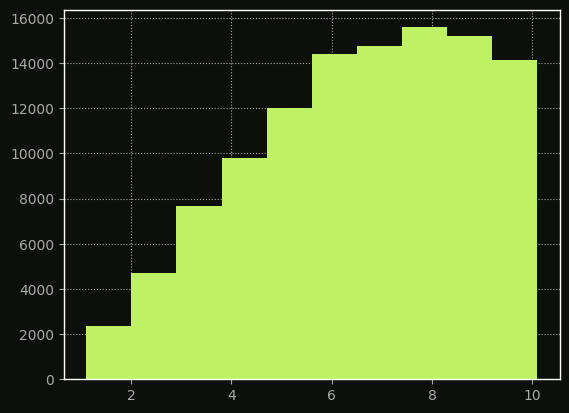

In [158]:
df["audio_duration"].hist()

In [31]:
# Select and rename relevant columns for clarity
styled_df = summary_df[["model","median_wer"]].drop_duplicates().copy()

# Use pandas Styler to colorize
def colorize(df):
    return (
        df.style
        .background_gradient(subset=["median_wer"], cmap="RdYlGn_r")  # green = fast
        .format({
            "median_wer": "{:.6f}",
        })
    )

# Display styled table
colorize(styled_df)


,model,median_wer
0,nvidia-parakeet-tdt-0.6b-v2,0.071429
4,openai-whisper-large-v3-turbo,0.071429
7,whisperx-large-v2,0.083333


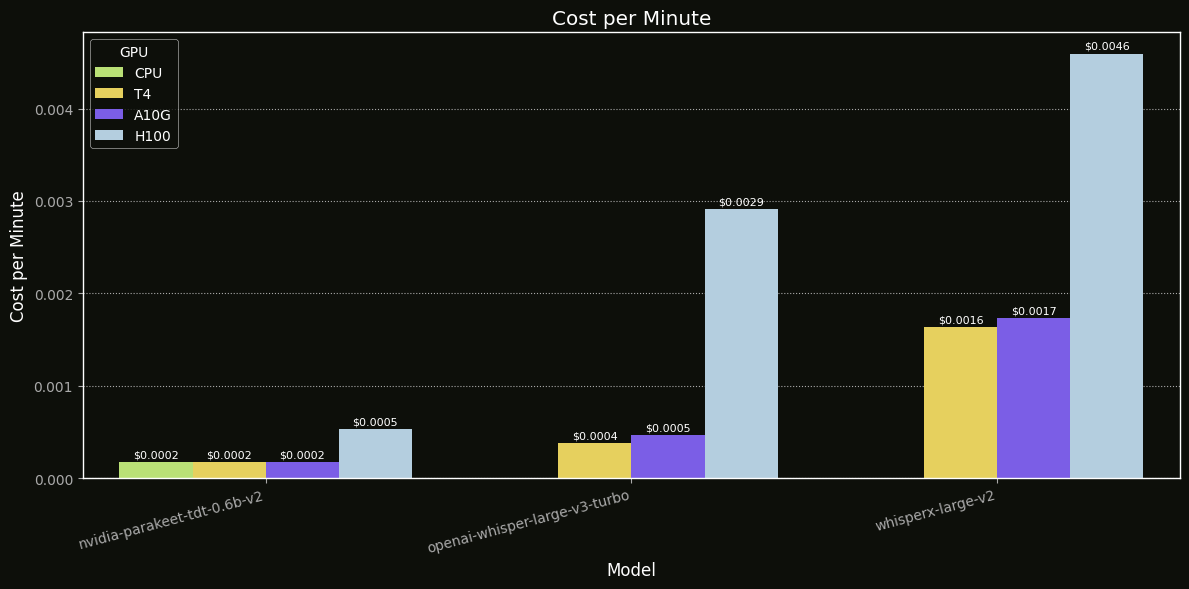

In [51]:
plt.figure(figsize=(12, 6))
# sns.set(style="whitegrid")

# Create grouped barplot
ax = sns.barplot(
    data=summary_df,
    x="model",
    y="cost_per_minute",
    hue="gpu",
    hue_order=gpus,
    palette=palette[:4]
)

# Add value labels on each bar
for container in ax.containers:
    ax.bar_label(container, fmt="$%.4f", fontsize=8, label_type="edge", padding=2)

# Customize axes and title
plt.xlabel("Model")
plt.ylabel("Cost per Minute")
plt.title("Cost per Minute")
plt.xticks(rotation=15, ha='right')
plt.legend(title="GPU")
plt.tight_layout()

# Save the figure
# plt.savefig("grouped_cost_chart.png")
plt.savefig(Path(OUTPUT_DIR, "audio_cost_per_minute_bar.webp"), dpi=DEFAULT_DPI)

plt.show()

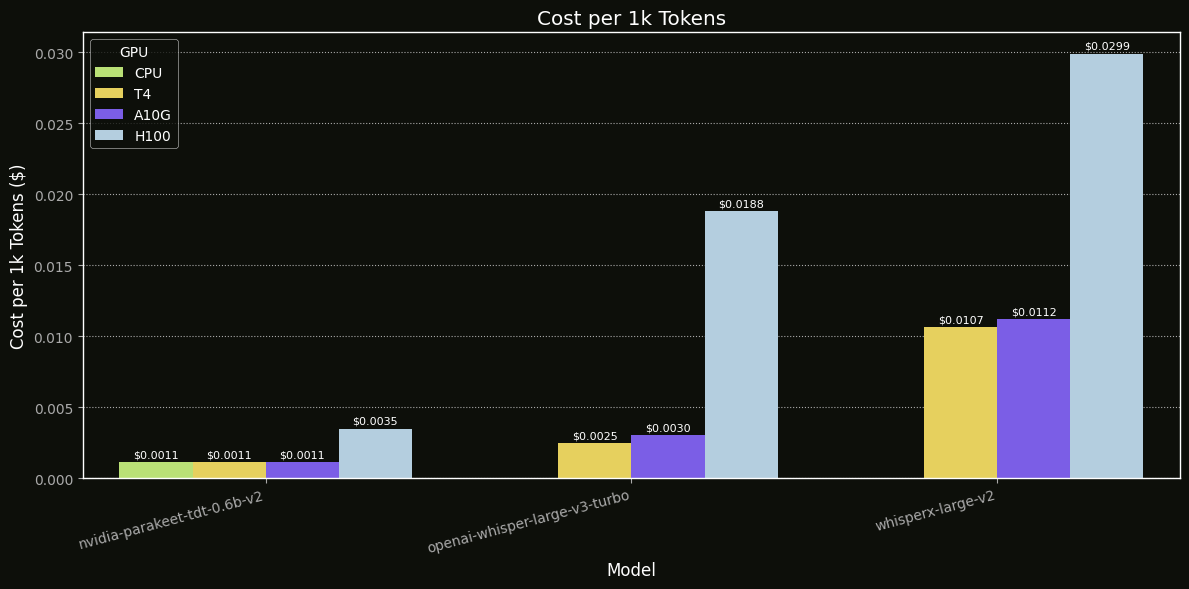

In [50]:
plt.figure(figsize=(12, 6))
# sns.set(style="whitegrid")

# Create grouped barplot
ax = sns.barplot(
    data=summary_df,
    x="model",
    y="cost_per_1k_tokens",
    hue="gpu",
    hue_order=gpus,
    palette=palette[:4]
)

# Add value labels on each bar
for container in ax.containers:
    ax.bar_label(container, fmt="$%.4f", fontsize=8, label_type="edge", padding=2)

# Customize axes and title
plt.xlabel("Model")
plt.ylabel("Cost per 1k Tokens ($)")
plt.title("Cost per 1k Tokens")
plt.xticks(rotation=15, ha='right')
plt.legend(title="GPU")
plt.tight_layout()

# Save the figure
# plt.savefig("grouped_cost_chart.png")
plt.savefig(Path(OUTPUT_DIR, "audio_cost_per_1k_bar.webp"), dpi=DEFAULT_DPI)

plt.show()

In [186]:
print(summary_df)

                           model   gpu       rtfx  cost_per_token  median_wer  \
0    nvidia-parakeet-tdt-0.6b-v2  A10G 106.972806        0.000001    0.071429   
1    nvidia-parakeet-tdt-0.6b-v2   CPU   4.628257        0.000001    0.071429   
2    nvidia-parakeet-tdt-0.6b-v2  H100 124.152685        0.000003    0.071429   
3    nvidia-parakeet-tdt-0.6b-v2    T4  57.729403        0.000001    0.071429   
4  openai-whisper-large-v3-turbo  A10G  39.258226        0.000003    0.071429   
5  openai-whisper-large-v3-turbo  H100  22.592707        0.000019    0.071429   
6  openai-whisper-large-v3-turbo    T4  25.928770        0.000002    0.071429   
7              whisperx-large-v2  A10G  10.627797        0.000011    0.083333   
8              whisperx-large-v2  H100  14.320318        0.000030    0.083333   
9              whisperx-large-v2    T4   6.013595        0.000011    0.083333   

   cost_per_1k_tokens  
0            0.001121  
1            0.001118  
2            0.003472  
3           

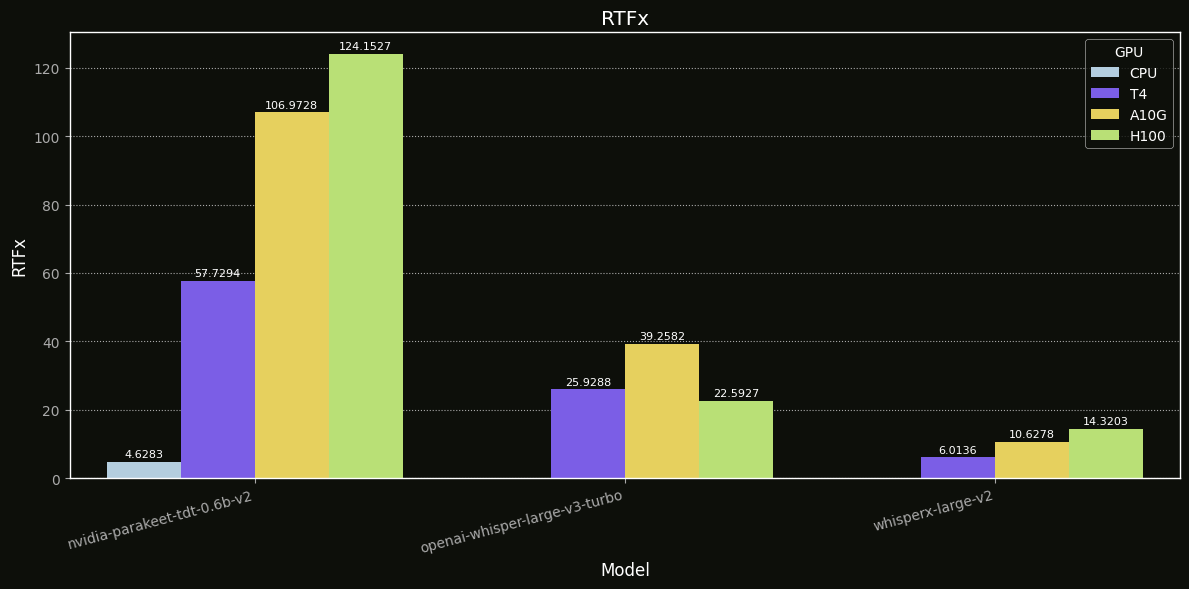

In [184]:
plt.figure(figsize=(12, 6))
# sns.set(style="whitegrid")

# Create grouped barplot
ax = sns.barplot(
    data=summary_df,
    x="model",
    y="rtfx",
    hue="gpu",
    hue_order=gpus,
    palette=palette[:4][::-1]
)

# Add value labels on each bar
for container in ax.containers:
    ax.bar_label(container, fmt="%.4f", fontsize=8, label_type="edge", padding=2)

# Customize axes and title
plt.xlabel("Model")
plt.ylabel("RTFx")
plt.title("RTFx")
plt.xticks(rotation=15, ha='right')
plt.legend(title="GPU")
plt.tight_layout()

# Save the figure
# plt.savefig("grouped_cost_chart.png")
plt.savefig(Path(OUTPUT_DIR, "audio_rtfx_bar.webp"), dpi=DEFAULT_DPI)
plt.show()

/var/folders/3g/ccy27sj915d9zdt_txn8fjtw0000gn/T/ipykernel_93943/3119517811.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


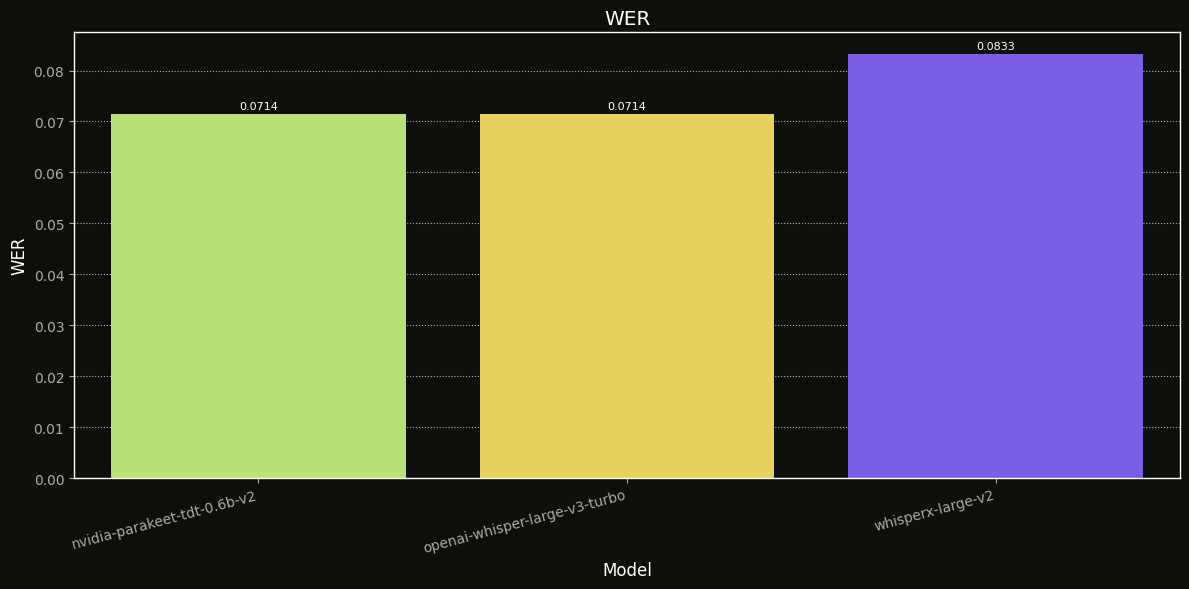

In [157]:
plt.figure(figsize=(12, 6))
wer_df = summary_df[["model","median_wer"]].drop_duplicates().copy()

# Create grouped barplot
ax = sns.barplot(
    data=wer_df,
    x="model",
    y="median_wer",
    # hue="gpu",
    # hue_order=gpus,
    palette=palette[:3]
)

# Add value labels on each bar
for container in ax.containers:
    ax.bar_label(container, fmt="%.4f", fontsize=8, label_type="edge", padding=2)

# Customize axes and title
plt.xlabel("Model")
plt.ylabel("WER")
plt.title("WER")
plt.xticks(rotation=15, ha='right')
# plt.legend(title="GPU")
plt.tight_layout()

# Save the figure
# plt.savefig("grouped_cost_chart.png")
plt.show()

In [139]:
# colors = dict(zip(gpus, palette[:len(gpus)]))

# # Plot setup
# fig, ax = plt.subplots(figsize=(12, 6))
# bar_width = 0.2
# gap = 0
# x_ticks = []
# x_labels = []

# x_pos = 0
# for model in models:
#     model_df = summary_df[summary_df["model"] == model]
#     for i, (_, row) in enumerate(model_df.iterrows()):
#         xpos = x_pos + i * (bar_width + gap)
#         ax.bar(xpos, row["cost_per_1k_tokens"], width=bar_width, color=colors[row["gpu"]], label=row["gpu"] if xpos == 0 else "")
#         ax.text(xpos, row["cost_per_1k_tokens"] + 0.0005, f"{row['cost_per_1k_tokens']:.4f}", ha='center', fontsize=8)
#         x_ticks.append(xpos)
#         x_labels.append(f"{model_to_display_name.get(model, model)} ({row['gpu']})")
#     x_pos += (len(model_df) + 1) * (bar_width + gap)

# # Final touches
# ax.set_xlabel("Model")
# ax.set_ylabel("Cost per 1k Tokens ($)")
# ax.set_title("Cost per 1k Tokens by Model and GPU (No Gaps)")
# ax.set_xticks(x_ticks)
# ax.set_xticklabels(x_labels, rotation=45, ha='right')
# ax.grid(axis='y')
# ax.legend(handles=[plt.Line2D([0], [0], color=colors[g], lw=10, label=g) for g in gpus], title="GPU Type")

# plt.tight_layout()
# # plt.savefig("grouped_cost_chart_nogaps.png")
# plt.show()

In [126]:
# colors = dict(zip(gpus, palette[:len(gpus)]))
# value_col = "cost_per_1k_tokens"
# fig, ax = plt.subplots(figsize=(12, 6))
# bar_width = 0.18
# intra_group_gap = 0.02
# inter_group_gap = 0.3
# x_ticks = []
# x_labels = []
# x_pos = 0

# for model in models:
#     model_df = summary_df[summary_df["model"] == model]
#     for i, (_, row) in enumerate(model_df.iterrows()):
#         xpos = x_pos + i * (bar_width + intra_group_gap)
#         ax.bar(xpos, row[value_col], width=bar_width, color=colors[row["gpu"]])
#         ax.text(xpos, row[value_col] + 0.0005, f"{row[value_col]:.4f}", ha='center', fontsize=8)
#         x_ticks.append(xpos)
#         x_labels.append(f"{model.split('-')[0]}-{row['gpu']}")
#     x_pos += len(model_df) * (bar_width + intra_group_gap) + inter_group_gap

# ax.set_ylabel(f"{value_col.replace('_', ' ').title()} ($)")
# ax.set_title(f"{value_col.replace('_', ' ').title()} by Model and GPU")
# ax.set_xticks(x_ticks)
# ax.set_xticklabels(x_labels, rotation=45, ha='right')
# ax.grid(axis='y')
# ax.legend(handles=[plt.Line2D([0], [0], color=colors[g], lw=10, label=g) for g in gpus], title="GPU Type")

# plt.tight_layout()
# # plt.savefig(output_file)
# plt.show()
# # plot_grouped_cost_chart(summary_df)